In [1]:
cd /home/tijmen/tudelft/thesis/metaengineering

/home/tijmen/tudelft/thesis/metaengineering


In [2]:
import pickle
import glob
import itertools
from typing import List, Callable

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.settings.tier import Tier
from src.settings.strategy import Strategy

In [3]:
def get_lime_df(tier: Tier, strategy: Strategy):
    paths = get_explanation_paths("lime", tier, strategy)
    df = pd.concat([pd.read_json(path) for path in paths])
    return df

def get_explanation_paths(type: str, tier: Tier, strategy: Strategy):
    explanation_path = f"/home/tijmen/tudelft/thesis/metaengineering/explanation/{tier}/{type}"
    paths = glob.glob(f"{explanation_path}/{strategy}_*")
    return paths
    
    
df = get_lime_df(tier=Tier.TIER0, strategy=Strategy.METABOLITE_CENTRIC)
df.iloc[0]['exp_enzymes']

['YLR438W',
 'YGR175C',
 'YER012W',
 'YJL171C',
 'YLR292C',
 'YMR149W',
 'YHR018C',
 'YEL037C',
 'YIL116W',
 'YKR080W',
 'YNR021W',
 'YNL104C',
 'YMR108W',
 'YJR016C',
 'YJR104C',
 'YBL045C',
 'YDR516C',
 'YLR061W',
 'YIL022W',
 'YOR374W',
 'YBR035C',
 'YKL145W',
 'YJL001W',
 'YJL008C',
 'YDL143W',
 'YDR427W',
 'YJL012C',
 'YOL012C',
 'YML008C',
 'YBR160W',
 'YNL241C',
 'YOR254C',
 'YOR251C',
 'YGL255W',
 'YBR249C',
 'YFR010W',
 'YIL063C',
 'YNL231C',
 'YKL060C',
 'YCR005C',
 'YGL011C',
 'YCR088W',
 'YHR107C',
 'YJL080C',
 'YNL239W',
 'YOL058W',
 'YLR027C',
 'YHR042W',
 'YPR036W',
 'YOR298C-A',
 'YNR001C',
 'YER057C',
 'YEL071W',
 'YLR351C',
 'YJR025C',
 'YER023W',
 'YBR106W',
 'YFL005W',
 'YGR155W',
 'YBR286W',
 'YOR046C',
 'YER062C',
 'YNL055C',
 'YCR004C',
 'YMR217W',
 'YLR378C',
 'YBR162C',
 'YBL030C',
 'YPR187W',
 'YKL112W',
 'YLR270W',
 'YDL100C',
 'YJR070C',
 'YNL216W',
 'YOR261C',
 'YEL060C',
 'YOR074C',
 'YPL143W',
 'YLR380W',
 'YGR086C',
 'YDL055C',
 'YJL153C',
 'YHR007C',
 '

In [4]:
def count_overlap(enzymes_one: List, enzymes_two: List):
    return len(set(enzymes_one[:5]) & set(enzymes_two[:5])) / len(enzymes_one[:5])

def kendalltau(enzymes_one: List, enzymes_two: List):
    from scipy.stats import kendalltau
    return kendalltau(enzymes_one, enzymes_two)[0]

def rank_correlation_metabolite_id(df: pd.DataFrame, metabolite_id: str, agg_func):
    _df = df[df['metabolite_id'] == metabolite_id].set_index('KO_ORF')
    return rank_correlation(_df, agg_func)

def rank_correlation_knockout(df: pd.DataFrame, knockout_id: str, agg_func):
    _df = df[df['KO_ORF'] == knockout_id].set_index('metabolite_id')
    return rank_correlation(_df, agg_func)

def rank_correlation_all(df: pd.DataFrame, agg_func: Callable):
    _df = df.reset_index()
    return rank_correlation(_df, agg_func)

def rank_correlation(_df: pd.DataFrame, agg_func: Callable):
    unique_knockouts = _df.index.to_list()
    knockout_combinations = list(itertools.combinations(unique_knockouts, r=2))
    
    n = len(unique_knockouts)
    r = np.ones((n, n))
    triu = np.triu_indices(n, 1)
    tril = np.tril_indices(n, -1)
    
    key = 'exp_enzymes'
    kendalltau_correllation = [agg_func(_df.loc[left_knockout][key], _df.loc[right_knockout][key]) for (left_knockout, right_knockout) in knockout_combinations]
    
    r[triu] = kendalltau_correllation
    r[tril] = r.T[tril]
    
    return r, unique_knockouts



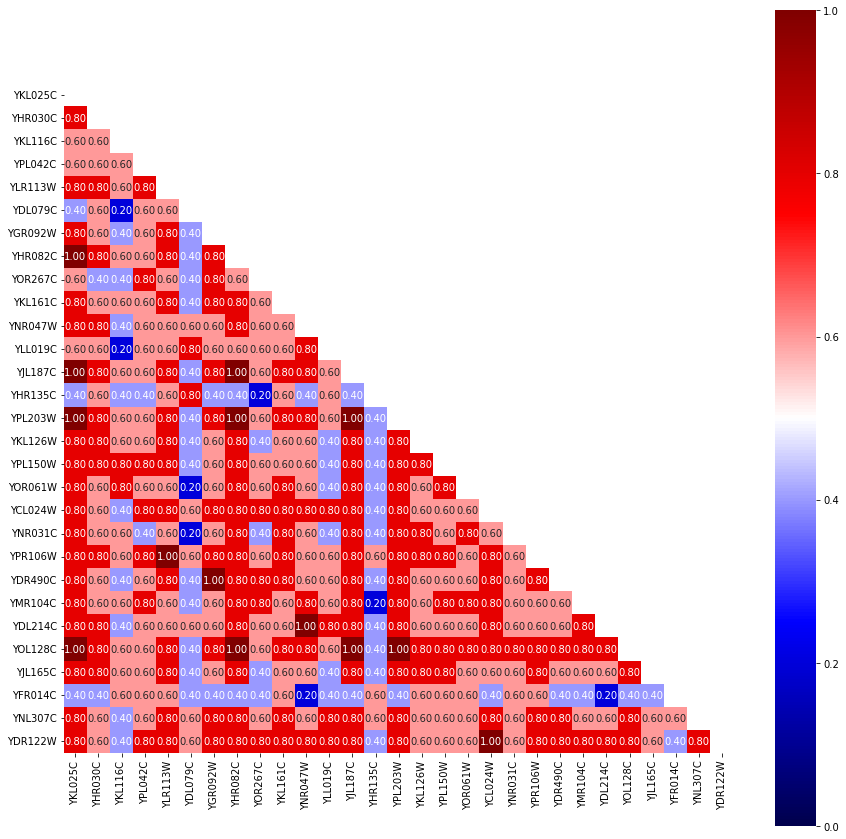

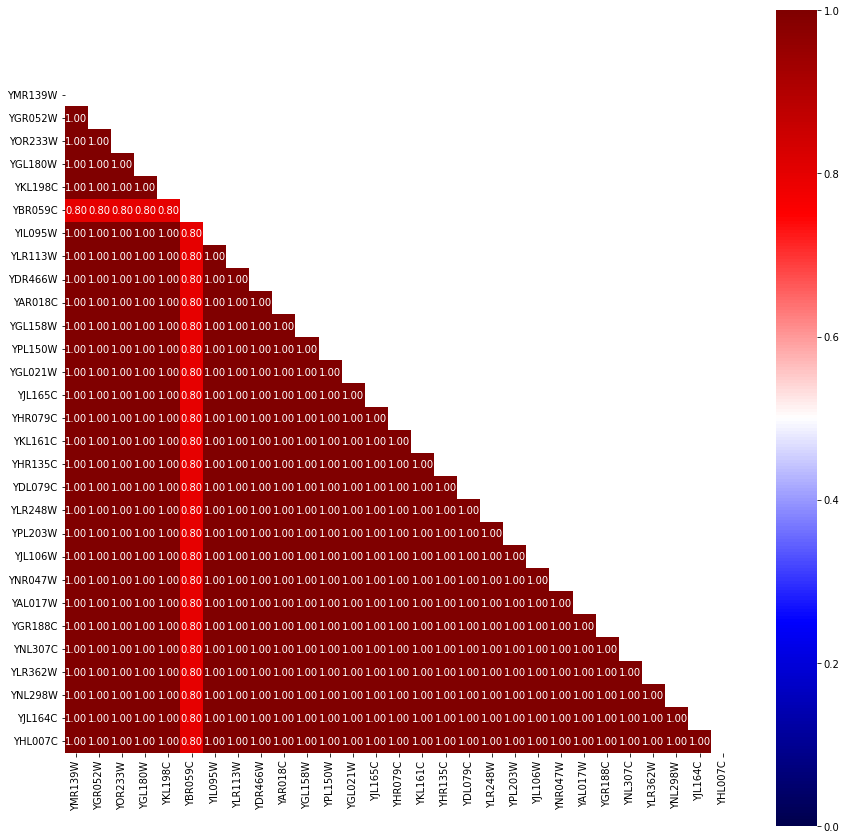

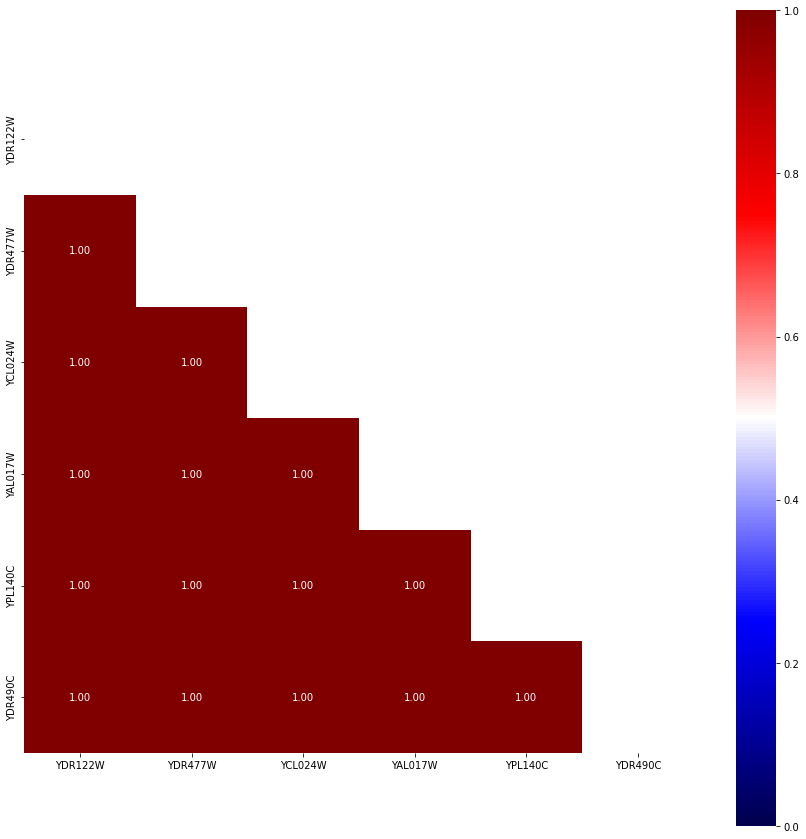

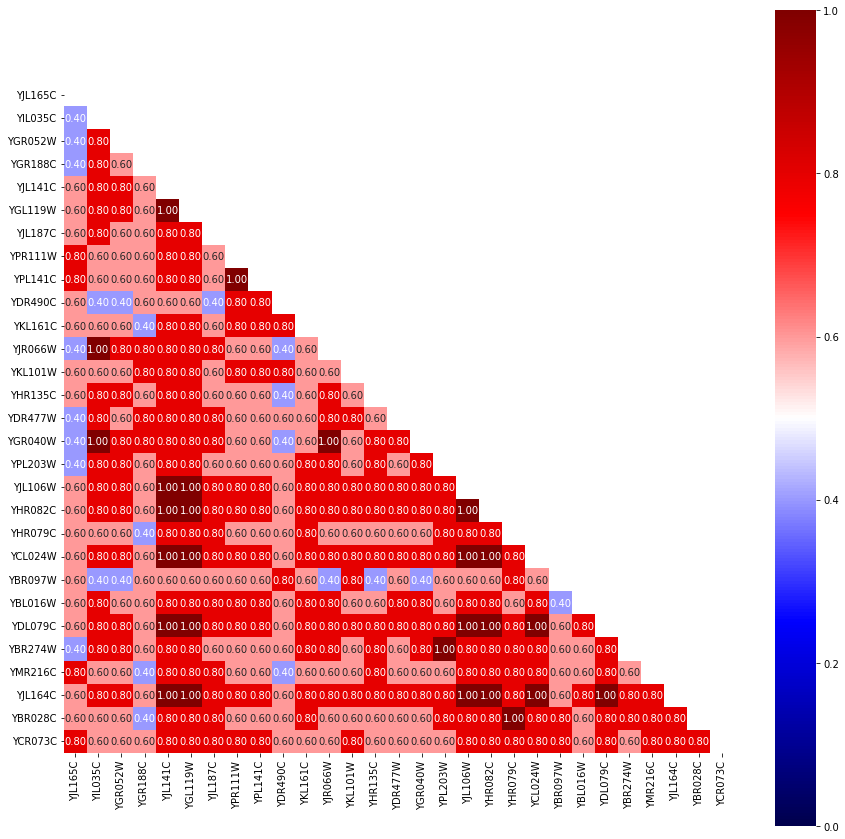

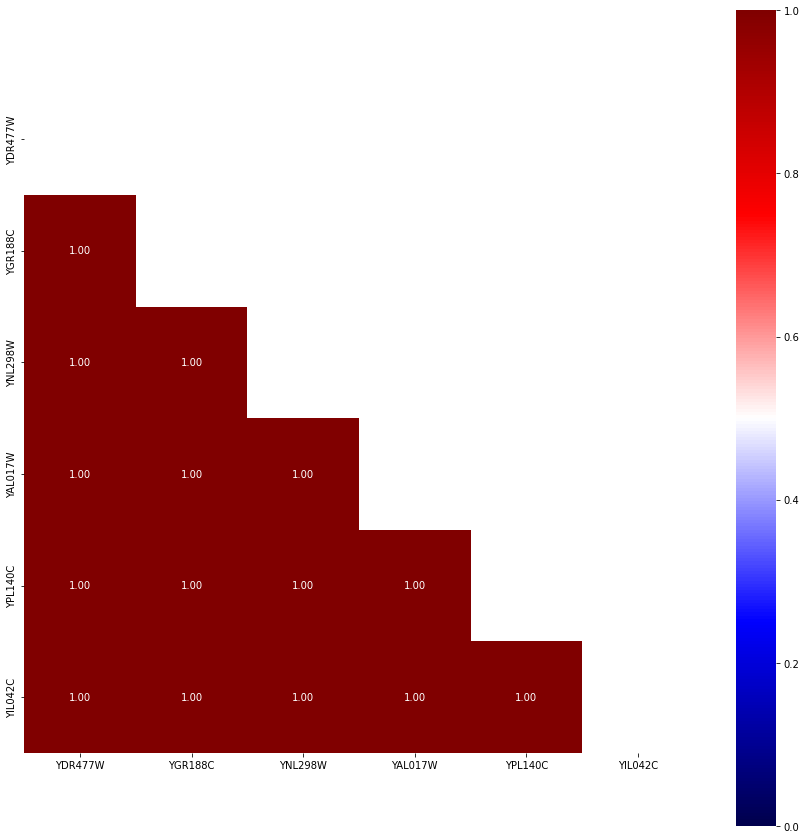

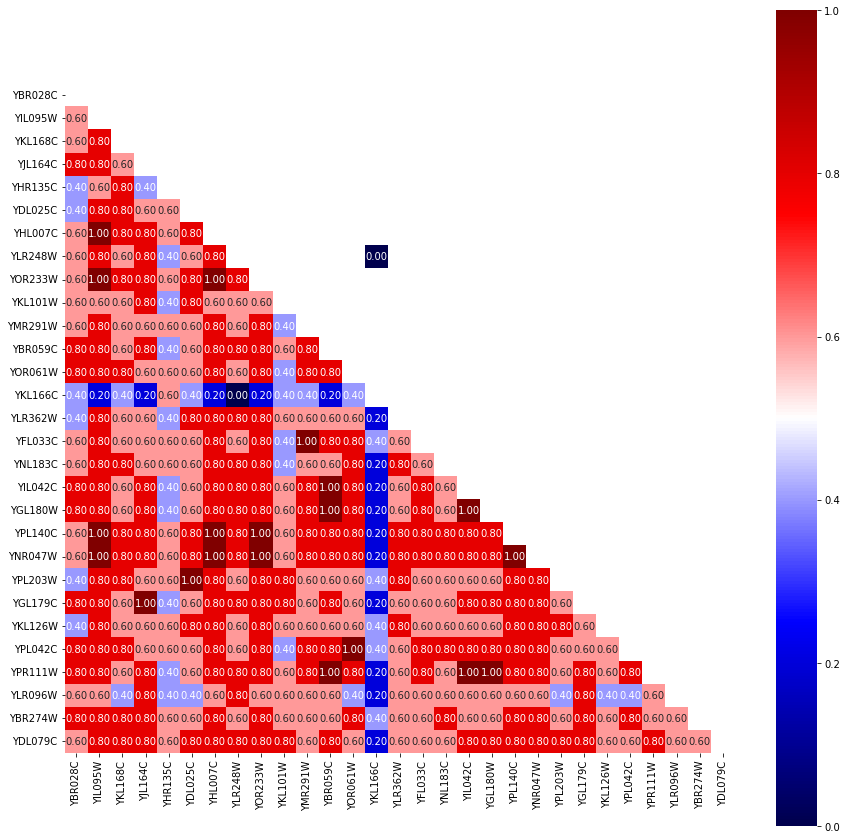

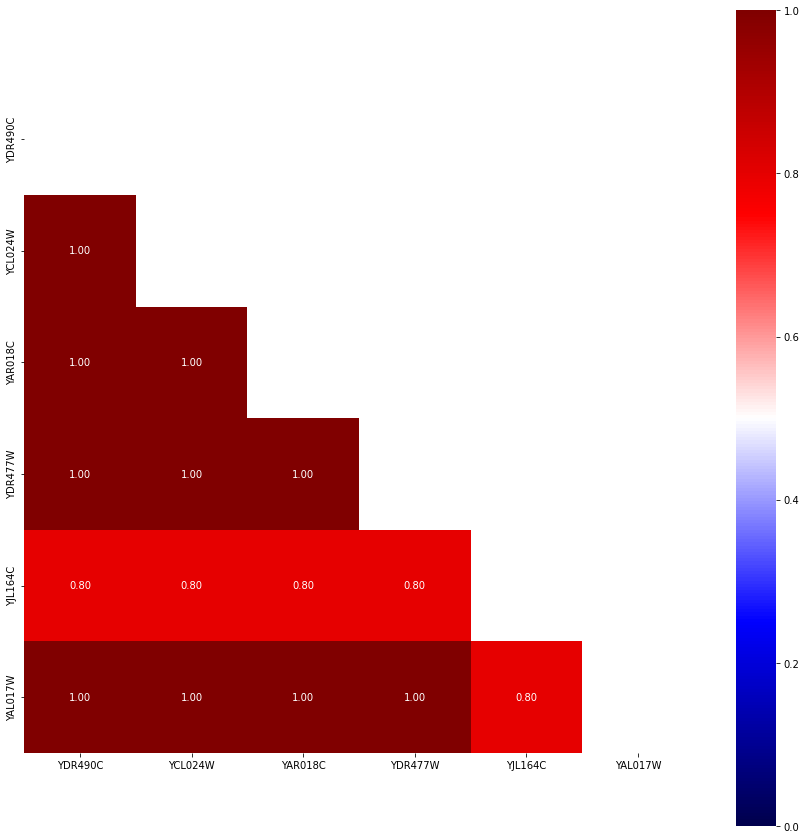

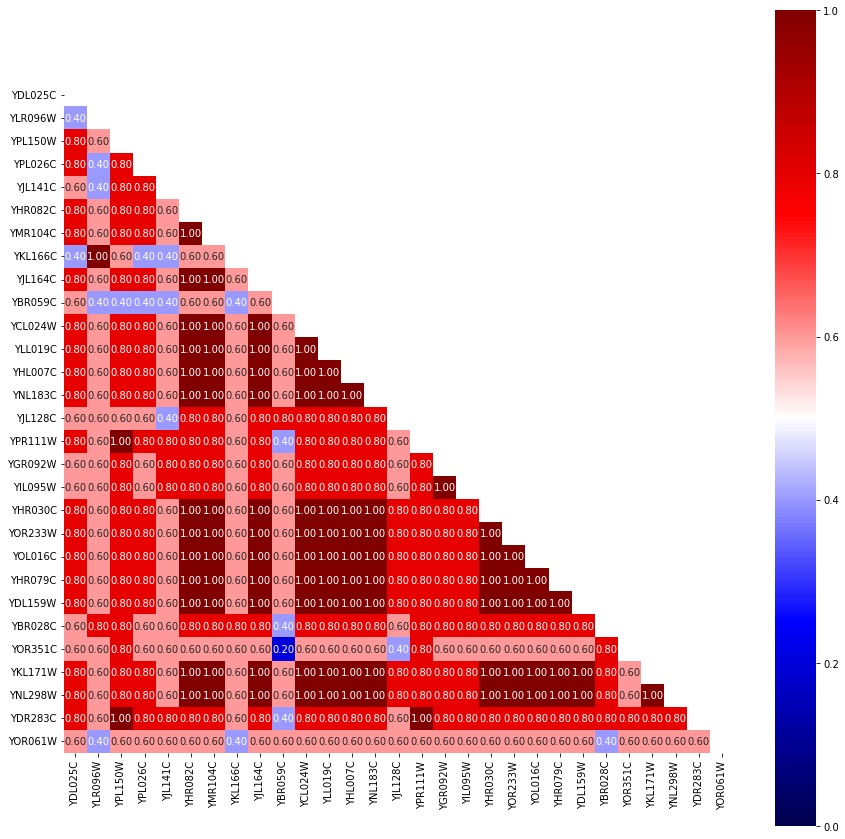

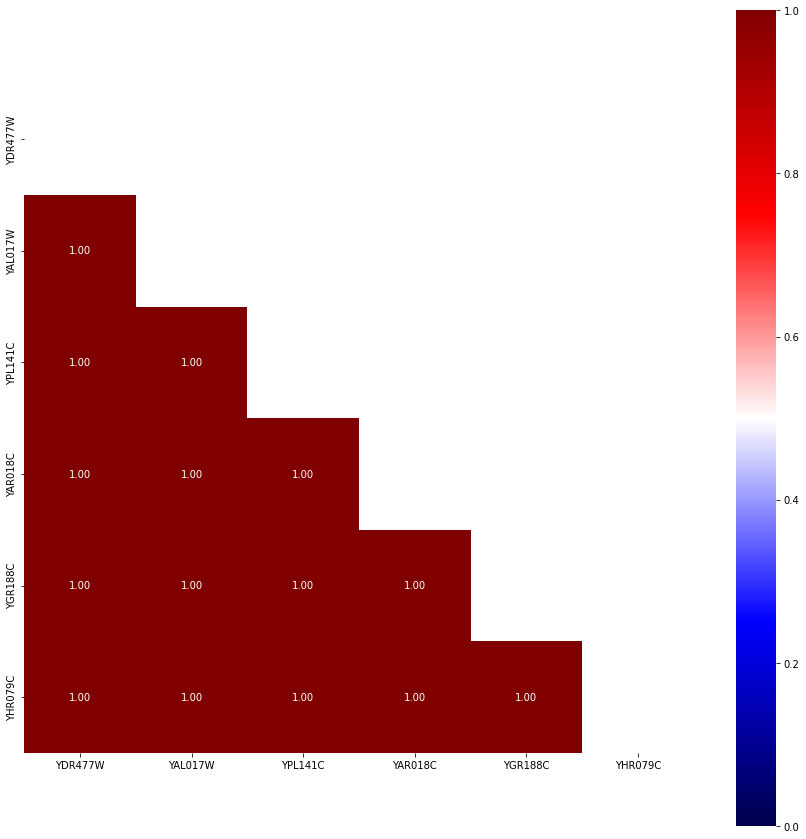

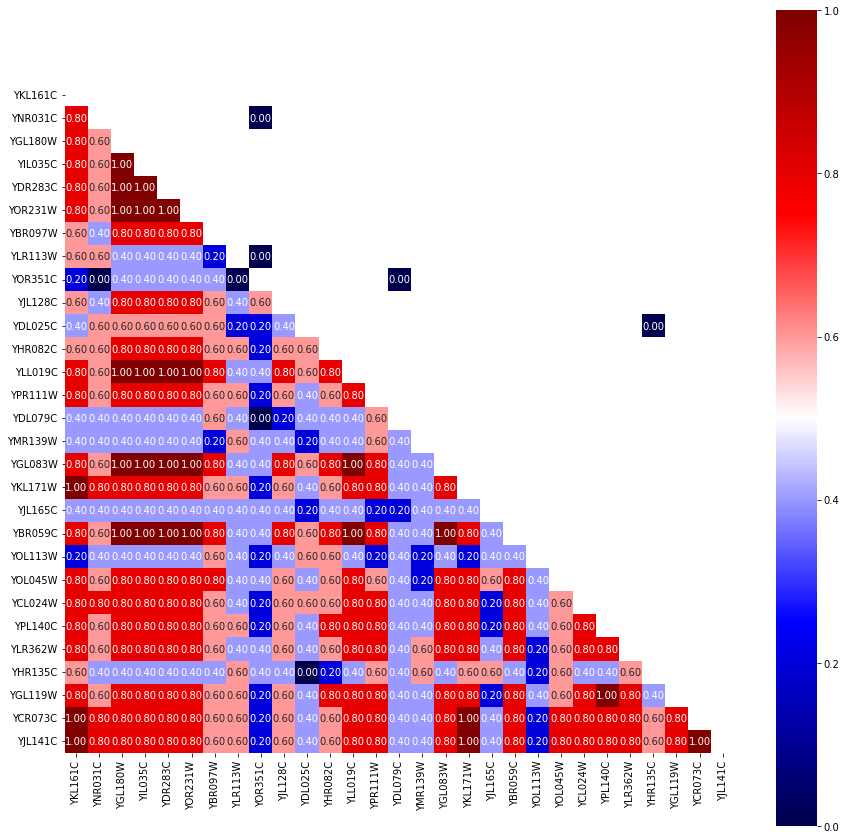

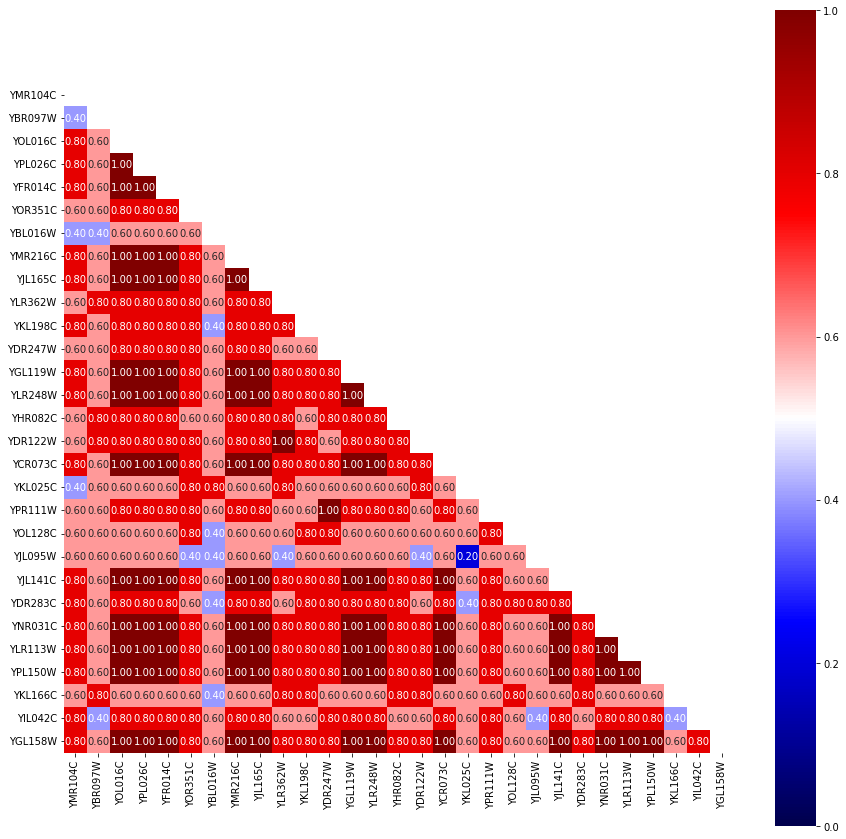

In [6]:
# correlation_matrix, knockouts = rank_correlation_knockout(df, 'YCL024W', count_overlap)
unique_metabolite_ids = df['metabolite_id'].unique()
for unique_metabolite_id in unique_metabolite_ids:
    correlation_matrix, knockouts = rank_correlation_metabolite_id(df, unique_metabolite_id, count_overlap)
    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(
        correlation_matrix, 
        square=True, 
        annot=True,
        fmt=".2f",
        vmax=1,
        vmin=0,
        ax=ax,
        xticklabels=knockouts,
        yticklabels=knockouts,
        cmap="seismic",
        mask=np.triu(correlation_matrix),
    )
    plt.savefig(f"./{unique_metabolite_id}.png")
# plt.tight_layout()
# plt.savefig('colorlist.png')

In [41]:
df

,KO_ORF,metabolite_id,exp_enzymes,exp_weights,y_true,y_pred
0,YKL025C,f6p,"[YLR438W, YGR175C, YER012W, YJL171C, YLR292C, ...","[0.0487194246, -0.0471058634, -0.0440300781, -...",0.242197,0.511720
1,YHR030C,f6p,"[YLR438W, YGR175C, YJL171C, YHR018C, YLR292C, ...","[0.0487494167, -0.0452278263, -0.0373108471, -...",0.323880,0.689692
2,YKL116C,f6p,"[YLR438W, YLR292C, YJL171C, YMR149W, YKR080W, ...","[0.048977535, 0.0310797433, -0.0308272692, 0.0...",0.558721,0.657218
3,YPL042C,f6p,"[YGR175C, YLR438W, YLR292C, YDR019C, YMR149W, ...","[-0.0468407828, 0.0457738669, 0.0334450421, 0....",0.886366,1.118056
4,YLR113W,f6p,"[YLR438W, YGR175C, YJL171C, YDR019C, YLR292C, ...","[0.0476184001, -0.0467505177, -0.0328013924000...",0.183384,0.884277
...,...,...,...,...,...,...
24,YLR113W,pyr,"[YDR346C, YFR010W, YML008C, YLR438W, YHR018C, ...","[0.0373726516, 0.0364312568, -0.036023485, 0.0...",0.519725,0.644183
25,YPL150W,pyr,"[YML008C, YLR438W, YFR010W, YDR346C, YHR018C, ...","[-0.0376767202, 0.0363487295, 0.035523552, 0.0...",0.200217,0.482445
26,YKL166C,pyr,"[YDR346C, YFR010W, YLR438W, YDR127W, YBR035C, ...","[0.0368083202, 0.036412008100000004, 0.0350467...",0.789834,0.787902
27,YIL042C,pyr,"[YML008C, YLR438W, YDR346C, YDR533C, YHR018C, ...","[-0.037705173700000004, 0.0367095563, 0.036529...",-0.258500,-0.634178


In [21]:


def get_unique_genes(df: pd.DataFrame):
    _df = df.explode(list(['exp_enzymes', 'exp_weights']))
    return _df['exp_enzymes'].unique()